# BME 인공지능 Homework #6
## 202001269 라현아

In [1]:
%matplotlib inline

### 준비사항
- 이번 실습을 위해서는 아래 코드의 실행을 통해 필요한 패키지들을 미리 설치하여야 합니다.
- 아래 패키지들을 성공적으로 설치한 후, 런타임을 다시 시작하여 다음 코드들을 실행하여 실습을 진행합니다.
- 실습코드는 아래 pytorch 공식사이트의 tutorial을 데이터를 가져오는 부분 위주로 일부분을 수정한 버젼으로 보다 자세한 내용은 링크를 참고 합니다.
  - https://pytorch.org/tutorials/beginner/translation_transformer.html


In [2]:
!pip install -U spacy
!pip install torchdata
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.2 MB 5.5 MB/s 
     |████████████████████████████████| 181 kB 67.2 MB/s 
     |████████████████████████████████| 457 kB 47.2 MB/s 
     |████████████████████████████████| 660 kB 53.1 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 10.1 MB 50.7 MB/s 
     |████████████████████████████████| 58 kB 6.3 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srs


nn.Transformer와 torchtext로 언어 번역하기
======================================================

이 튜토리얼에서는 Transformer(트랜스포머)를 사용한 번역 모델을 바닥부터 학습하는 방법을 배워보겠습니다. 

In [3]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## 학습을 위한 Vocab, Data Loader 를 준비하기

In [4]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k, IWSLT2016, IWSLT2017
from typing import Iterable, List
from torchtext.utils import download_from_url, extract_archive
import io

SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'de'

# Place-holders
token_transform = {}
vocab_transform = {}

# 출발어(source)와 목적어(target)의 토크나이저(tokenizer)를 생성합니다.
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')

# 토큰 목록을 생성하기 위한 헬퍼(helper) 함수
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# 특수 기호(symbol)와 인덱스를 정의합니다
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# 토큰들이 어휘집(vocab)에 인덱스 순서대로 잘 삽입되어 있는지 확인합니다
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']


In [5]:
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.en.gz', 'train.de.gz')
val_urls = ('val.en.gz', 'val.de.gz')
test_urls = ('test_2016_flickr.en.gz', 'test_2016_flickr.de.gz')

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

100%|██████████| 569k/569k [00:00<00:00, 15.0MB/s]
100%|██████████| 637k/637k [00:00<00:00, 16.6MB/s]
100%|██████████| 21.6k/21.6k [00:00<00:00, 8.08MB/s]
100%|██████████| 24.7k/24.7k [00:00<00:00, 5.13MB/s]
100%|██████████| 21.1k/21.1k [00:00<00:00, 7.33MB/s]
100%|██████████| 22.9k/22.9k [00:00<00:00, 5.34MB/s]


In [6]:
def iter_tokens(file_path):
  with io.open(file_path, encoding = 'utf-8') as f:
    for line in f:
      yield line.strip().split()

In [7]:
# 문자 -> 숫자
vocab_transform[SRC_LANGUAGE] = build_vocab_from_iterator(iter_tokens(train_filepaths[0]),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)
vocab_transform[TGT_LANGUAGE] = build_vocab_from_iterator(iter_tokens(train_filepaths[1]),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

In [8]:
len(vocab_transform[SRC_LANGUAGE])

15460

In [9]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [10]:
vocab_transform['en']['water'] # 단어 <-> 숫자 맵핑 확인
# cf) 숫자 -> 단어 가져오기: embedding

86

In [11]:
def data_process(filepaths):
  raw_en_iter = iter(io.open(filepaths[0], encoding="utf8"))
  raw_de_iter = iter(io.open(filepaths[1], encoding="utf8"))
  data = []
  for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
    en_tensor_ = torch.tensor([vocab_transform[SRC_LANGUAGE][token] for token in token_transform[SRC_LANGUAGE](raw_en)],
                            dtype=torch.long)
    de_tensor_ = torch.tensor([vocab_transform[TGT_LANGUAGE][token] for token in token_transform[TGT_LANGUAGE](raw_de)],
                            dtype=torch.long)
    data.append((en_tensor_, de_tensor_))
  return data

In [12]:
train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)

In [13]:
train_data[0][0] # [k][0] : 영어 , [k][1] 독일어

tensor([  17,   22,    0, 1315,  868,   14,   66,   77,  311, 4937,    0,    0])

In [14]:
vocab_transform[TGT_LANGUAGE].lookup_tokens(train_data[16][1].numpy())

['Ein',
 'kleines',
 'Mädchen',
 'sitzt',
 'vor',
 'einem',
 'großen',
 'gemalten',
 'Regenbogen',
 '.',
 '<unk>']

Transformer를 사용한 시퀀스-투-시퀀스(Seq2Seq) 신경망
------------------------------------------------------------

Transformer(트랜스포머)는 기계번역 작업(task)을 위해 "Attention is all you need" 논문에 소개된 Seq2Seq 모델입니다.
아래에서 Transformer를 사용한 Seq2Seq 신경망을 만들어보겠습니다.
신경망은 세 부분으로 구성되는데, 
- 첫번째 부분은 임베딩 계층(embedding layer)입니다.
이 계층은 입력 인덱스의 텐서를 입력 임베딩의 해당하는 텐서로 변환합니다.
이러한 임베딩은 입력 토큰의 위치 정보(position information)를 모델에 전달하기 위해 위치 인코딩(positional encoding)을 추가합니다.
- 두번째 부분은 실제 Transformer 모델입니다.
- 마지막으로 Transformer 모델의 출력을 선형 계층에 통과시켜 도착어의 각 토큰에 대한 정규화되지 않은 확률(un-normalized probability)로 제공합니다.




In [15]:
# 단어 순서 개념(notion)을 토큰 임베딩에 도입하기 위한 위치 인코딩(positional encoding)을 위한 헬퍼 모듈(Module)
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# 입력 인덱스의 텐서를 해당하는 토큰 임베딩의 텐서로 변환하기 위한 헬퍼 모듈(Module)
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        ## 임베딩 vocab_size (단어개수) -> emb_size (실제 input 벡터의 개수) => one-hot encoding (x)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq 신경망
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

학습하는 동안, 모델이 예측하는 동안 정답(이후 출현하는 단어)을 보지 못하도록 하는
후속 단어 마스크(subsequent word mask)가 필요합니다. 또한, 출발어와 도착어의 패딩(padding) 토큰들
또한 숨겨야 합니다. 아래에 두 가지 모두를 처리할 함수를 정의해보겠습니다.




In [16]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

이제 모델의 매개변수를 정의하고 객체를 생성(instantiate)해보겠습니다.
아래처럼 학습 단계에서 사용할 손실 함수(loss function)를 교차 엔트로피 손실(cross-entropy loss)로 정의하고,
옵티마이저(optimizer)도 정의합니다.




In [17]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 1024
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 256
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.00015, betas=(0.9, 0.98), eps=1e-9)

대조(Collation)
-----------------

위의 ``데이터 구하고 처리하기`` 장에서 봤듯이, 데이터 반복자(iterator)는 원시 문자열의 쌍을 생성합니다.
이 문자열 쌍들을 이전에 정의한 ``Seq2Seq`` 신경망에서 처리할 수 있도록 텐서 묶음(batched tensor)으로 변환해야 합니다.
이제 원시 문자열들의 묶음(batch)을 텐서 묶음으로 변환하여 모델에 직접 전달할 수 있도록 하는 대응어(collate) 함수를
정의해보겠습니다.




In [18]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [19]:
# 순차적인 작업들을 하나로 묶는 헬퍼 함수
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# BOS/EOS를 추가하고 입력 순서(sequence) 인덱스에 대한 텐서를 생성하는 함수
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# 출발어(src)와 도착어(tgt) 원시 문자열들을 텐서 인덱스로 변환하는 변형(transform)
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], # 토큰화(Tokenization)
                                               vocab_transform[ln], # 수치화(Numericalization)
                                               tensor_transform) # BOS/EOS를 추가하고 텐서를 생성

# 데이터를 텐서로 조합(collate)하는 함수
def collate_fn(data_batch):
  en_batch, de_batch = [], []
  for (en_item, de_item) in data_batch:
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
    de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
  de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
  return en_batch, de_batch

각 에폭(epoch)마다 호출할 학습 및 검증(evaluation) 단계를 정의해보겠습니다.




In [20]:

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0
    val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

### 학습된 번역모델을 편하게 사용하기 위해 몇 가지 함수를 정의합니다.

In [21]:
# 탐욕(greedy) 알고리즘을 사용하여 출력 순서(sequence)를 생성하는 함수
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# 입력 문장을 도착어로 번역하는 함수
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

- 학습이 진행되지 않은 모델에 문장을 넣게 되면 의미없는 결과를 출력할 것 입니다.

In [22]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu."))

 Büroarbeit Büroarbeit Büroarbeit Büroarbeit Büroarbeit Büroarbeit Büroarbeit Büroarbeit Büroarbeit Büroarbeit abzufangen, dadurch abzufangen, dadurch abzufangen,


## 학습 진행하기
이제 모델 학습을 위한 모든 요소가 준비되었습니다. 학습을 해보겠습니다!




In [23]:
from timeit import default_timer as timer
NUM_EPOCHS = 10

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 5.167, Val loss: 3.851, Epoch time = 62.857s
Epoch: 2, Train loss: 3.420, Val loss: 2.883, Epoch time = 62.818s
Epoch: 3, Train loss: 2.632, Val loss: 2.377, Epoch time = 62.804s
Epoch: 4, Train loss: 2.139, Val loss: 2.067, Epoch time = 62.792s
Epoch: 5, Train loss: 1.807, Val loss: 1.919, Epoch time = 62.803s
Epoch: 6, Train loss: 1.567, Val loss: 1.846, Epoch time = 62.820s
Epoch: 7, Train loss: 1.378, Val loss: 1.785, Epoch time = 62.836s
Epoch: 8, Train loss: 1.226, Val loss: 1.798, Epoch time = 62.794s
Epoch: 9, Train loss: 1.095, Val loss: 1.760, Epoch time = 62.794s
Epoch: 10, Train loss: 0.979, Val loss: 1.748, Epoch time = 62.805s


- 학습이 진행된 모델에 독일어 문장을 넣고 결과를 확인해 봅시다.

In [40]:
print(translate(transformer, "just two of us in here."))

 Zwei Männer bringen ich was ich <unk> . <unk> 


참고자료
----------

1. Attention is all you need 논문.
   https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf
2. Transformer에 대한 설명. https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding




## 1. 최종 모델에 사용한 Hyperparameter의 값들
- EMB_SIZE = 1024
- NHEAD = 8
- FFN_HID_DIM = 512
- BATCH_SIZE = 256
- NUM_ENCODER_LAYERS = 3
- NUM_DECODER_LAYERS = 3
- optimizer Ir = 0.00015

## 2. Training 과정에서의 epoch별 loss 변화

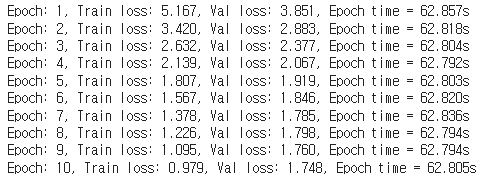




## 3. 비교적 번역이 괜찮은 문장을 최소 2개 이상 (구글번역과 결과 비교)

### (1) "Children like orange candy."

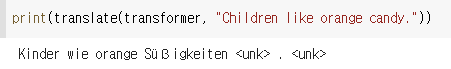

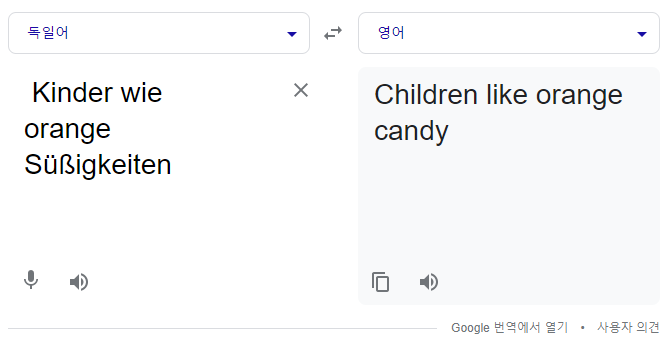

### (2) "She wears a green skirt."
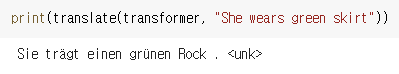

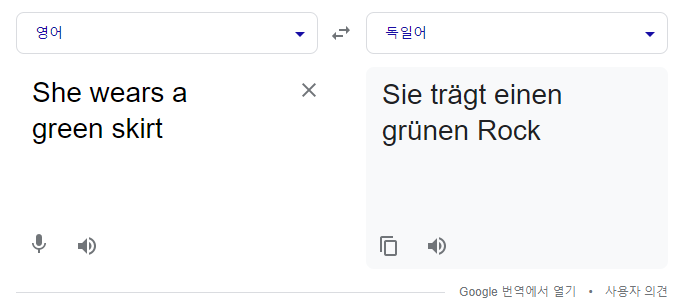

### (3) "He buys many drinks for the party."

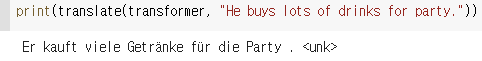

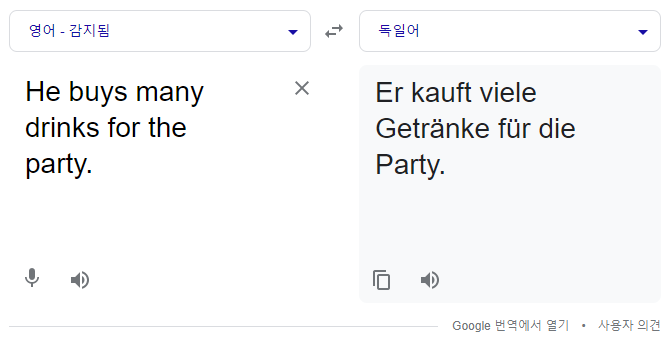

## 4. 번역이 매우 좋지 않은 문장을 최소 2개 이상 (구글번역과 결과 비교)

### (1) "I have much assignment."

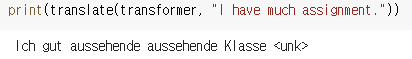

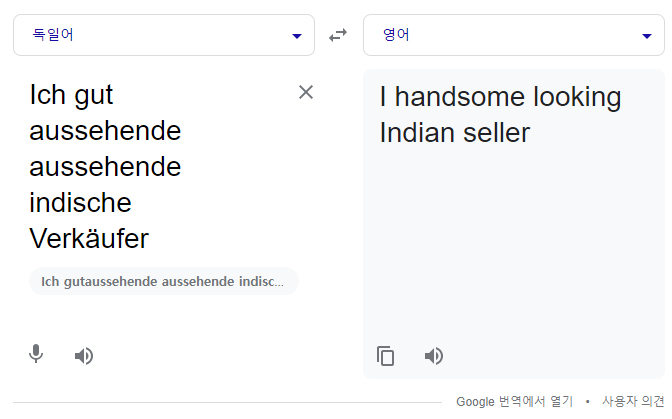

### (2) "just two of us in here."

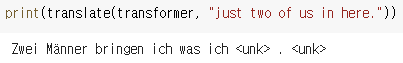

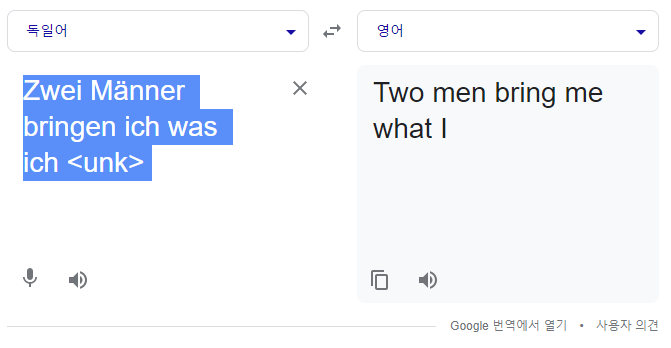